In [1]:
from resources.test_QECC import *
import matplotlib.pyplot as plt

## a) Implementation: Circuit Components for the 5 Qubit Code
The 5 Qubit Code is a stabilizer code generated by
$$
\begin{aligned}
S_0 &= XZZXI \\
S_1 &= IXZZX \\
S_2 &= XIXZZ \\
S_3 &= ZXIXZ
\end{aligned}
$$

Using these generators as a starting point, we will discuss and show the implementation of each of the necessary circuit components in turn. We will need the $5$ qubits for the code, $4$ qubits for checking errors, $4$ classical bits to hold the measurements of those error qubits (the syndromes), and $5$ classical bits to hold the final measurement of the code qubits:

In [2]:
qubits_code = QuantumRegister(size=5, name='code')
qubits_checks = AncillaRegister(size=4, name='check')
syndromes = ClassicalRegister(4, name='syndromes')
clbits_code = ClassicalRegister(5, name='code_measurements')

### a.i) State Preparation
It is not too difficult to find by hand the projection of the state $\left|00000\right>$ onto the mutual $+1$ eigenvalue subspace for all the generators (and thus of all the stabilizers). We find
$$
\begin{aligned}
\left[\prod_{i=0}^{3} \frac{I+S_i}{2}\right] \left|00000\right> = \left|00000\right> & + \left|00101\right> + \left|01010\right> + \left|10100\right>  + \left|01001\right>  + \left|10010\right> \\
& - \left|00011\right> - \left|00110\right> - \left|01100\right> - \left|11000\right> - \left|10001\right>\\
& - \left|01111\right> - \left|11110\right> - \left|11101\right> - \left|11011\right> - \left|10111\right>
\end{aligned}
$$
Here we use Qiskit's built-in state preparation gate to transform $\left|00000\right>$ into the logical $0$ state, $\left|0_L\right>$, which is the normalized version of the above:

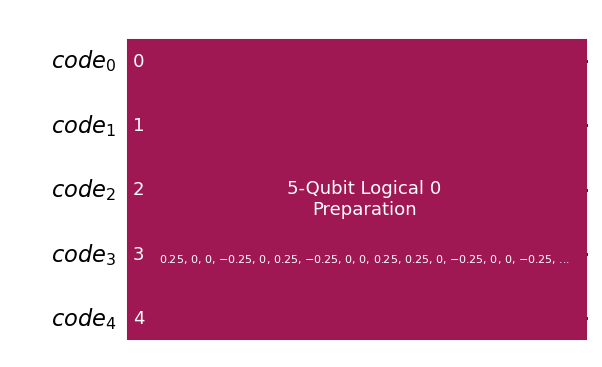

In [3]:
logical0_components_coef_plus1 = ['00000','00101','01010','10100','01001','10010']
logical0_components_coef_minus1 = ['00011','00110','01100','11000','10001','01111','11110','11101','11011','10111']

logical0_coefficients = np.zeros((2**5))
logical0_coefficients[[int(c,2) for c in logical0_components_coef_plus1]] = 1
logical0_coefficients[[int(c,2) for c in logical0_components_coef_minus1]] = -1
logical0_prep = StatePreparation(logical0_coefficients, normalize=True, label='5-Qubit Logical 0\nPreparation')

QuantumCircuit(qubits_code).compose(logical0_prep).draw(output='mpl')

### a.ii) Error Checking and Syndrome Measurement
We use a standard construction for an error checking circuit that is derived directly from the generators. While likely far less efficient than the most efficient circuit for the 5 Qubit Code, it is straightforward to assemble, especially since the generators are cyclic permutations of each other.

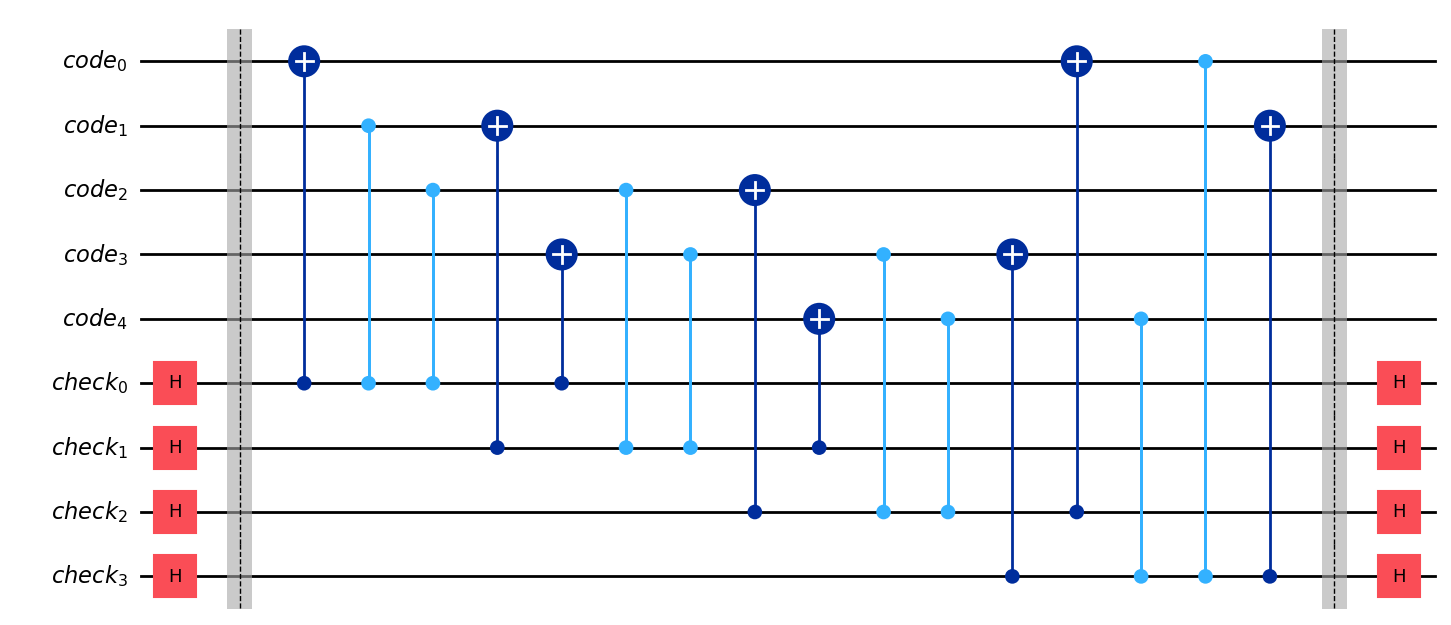

In [4]:
qc = QuantumCircuit(qubits_code, qubits_checks)

# initial Hadamards on checker qubits
qc.h(qubits_checks[:])
qc.barrier()

# apply controlled gates in the same pattern as the generators
for i in range(4): # i=0: XZZXI --rotate right--> i=1: IXZZX -> i=2: XIXZZ -> i=3: ZXIXZ
    qc.cx(qubits_checks[i], qubits_code[i%5])     # X on qubit i (mod 5)
    qc.cz(qubits_checks[i], qubits_code[(i+1)%5]) # Z on qubit i+1 (mod 5)
    qc.cz(qubits_checks[i], qubits_code[(i+2)%5]) # Z on qubit i+2 (mod 5)
    qc.cx(qubits_checks[i], qubits_code[(i+3)%5]) # X on qubit i+3 (mod 5)
    # nothing for I on qubit i+4 (mod 5)

# 'undo' the Hadamards
qc.barrier()
qc.h(qubits_checks[:])

qc.draw(output='mpl')

### a.iii) Error Correction
Note that there are $2^4 = 16$ different possible syndrome bit strings that can result from a measurement of the checker qubits. And, on the five code qubits, there are $5\cdot3=15$ possible weight-$1$ Pauli errors. Including the null error, there are exactly as many possible up-to-weight-$1$ errors as there are syndrome patterns. Assuming that each weight-$1$ Pauli error produces a unique syndrome pattern, there is a unique lowest-weight choice in how to remedy any pattern. Here, we test that assumption by tracking possible syndrome bit strings due to weight-$1$ errors (in `remedy_dict` below) and, at the same time, build up the remedy circuit.

In [5]:
qc = QuantumCircuit(qubits_code, syndromes)
remedy_dict = {} # dictionary with keys = integer representations of the syndrome bit string

Note that a single $X$ error on a single code qubit $c_j$ will trigger a syndrome if and only if the corresponding generator $S_i$ has a $Z$ in position $j$. Since each generator is cyclically shifted to the right as compared with the previous one, $S_i$ will have a $Z$ in position $j$ when $S_0$ has a $Z$ in position $j-i \pmod 5$. Since $S_0$ has $Z$s in positions $1$ and $2$, an $X$ error on $c_j$ will trigger syndromes $i=j-1 \pmod 5$ and $i=j-2 \pmod 5$.

In [6]:
for j in range(5): # loop over the position of an X error
     # get the integer encoding of the syndrome bit string
    syndromes_int = 2**((j-1)%5) + 2**((j-2)%5)

    # remove the most significant bit in the syndrome integer; it corresponds to the 5th cyclic variation of the generators,
    # which is redundant and not measured
    syndromes_int = syndromes_int % (2**4)
    
    # store the syndrome integer-remedy pair; the remedy here is just to undo the X error on qubit j
    remedy_dict[syndromes_int] = ('X', j) 
    with qc.if_test((syndromes, syndromes_int)):
        qc.x(qubits_code[j])

Similarly, a single $Z$ error on a single qubit $c_j$ will trigger a syndrome if and only if the corresponding generator $S_i$ has a $X$ in position $j$. Since $S_0$ has $X$'s in positions $0$ and $3$, a $Z$ error on $c_j$ will trigger syndromes $i=j \pmod 5$ and $i=j-3 \pmod 5$.

In [7]:
for j in range(5): # loop over the position of a Z error
     # get the integer encoding of the syndrome bit string
    syndromes_int = 2**(j%5) + 2**((j-3)%5)
    syndromes_int = syndromes_int % (2**4)
    
    # store the syndrome integer-remedy pair; the remedy here is just to undo the Z error on qubit j
    remedy_dict[syndromes_int] = ('Z', j) 
    with qc.if_test((syndromes, syndromes_int)):
        qc.z(qubits_code[j])

Lastly, a single $Y$ error on a single qubit $c_j$ will trigger a syndrome if and only if the corresponding generator $S_i$ has either $X$ or $Z$ in position $j$. Since $S_0$ has $X$'s or $Z$'s in all positions besides $4$, a $Y$ error on $c_j$ will trigger all syndromes besides $i=(j-4) \pmod 5$.

In [8]:
for j in range(5): # loop over the position of a Y error
     # get the integer encoding of the syndrome bit string by subtracing the integer encoding of its bitwise negation from 11111_2 = 31
    syndromes_int = 31 - 2**((j-4)%5)
    syndromes_int = syndromes_int % (2**4)
    
    # store the syndrome integer-remedy pair; the remedy here is just to undo the Z error on qubit j
    remedy_dict[syndromes_int] = ('Y', j) 
    with qc.if_test((syndromes, syndromes_int)):
        qc.y(qubits_code[j])

That is all the possible weight-1 errors, and they are in one-to-one correspondence with the (non-zero) syndrome integers:

In [9]:
remedy_dict

{8: ('X', 0),
 1: ('X', 1),
 3: ('X', 2),
 6: ('X', 3),
 12: ('X', 4),
 5: ('Z', 0),
 10: ('Z', 1),
 4: ('Z', 2),
 9: ('Z', 3),
 2: ('Z', 4),
 13: ('Y', 0),
 11: ('Y', 1),
 7: ('Y', 2),
 15: ('Y', 3),
 14: ('Y', 4)}

This implies that the generated circuit is offers the minimal weight remedy for each possible syndrome pattern: 

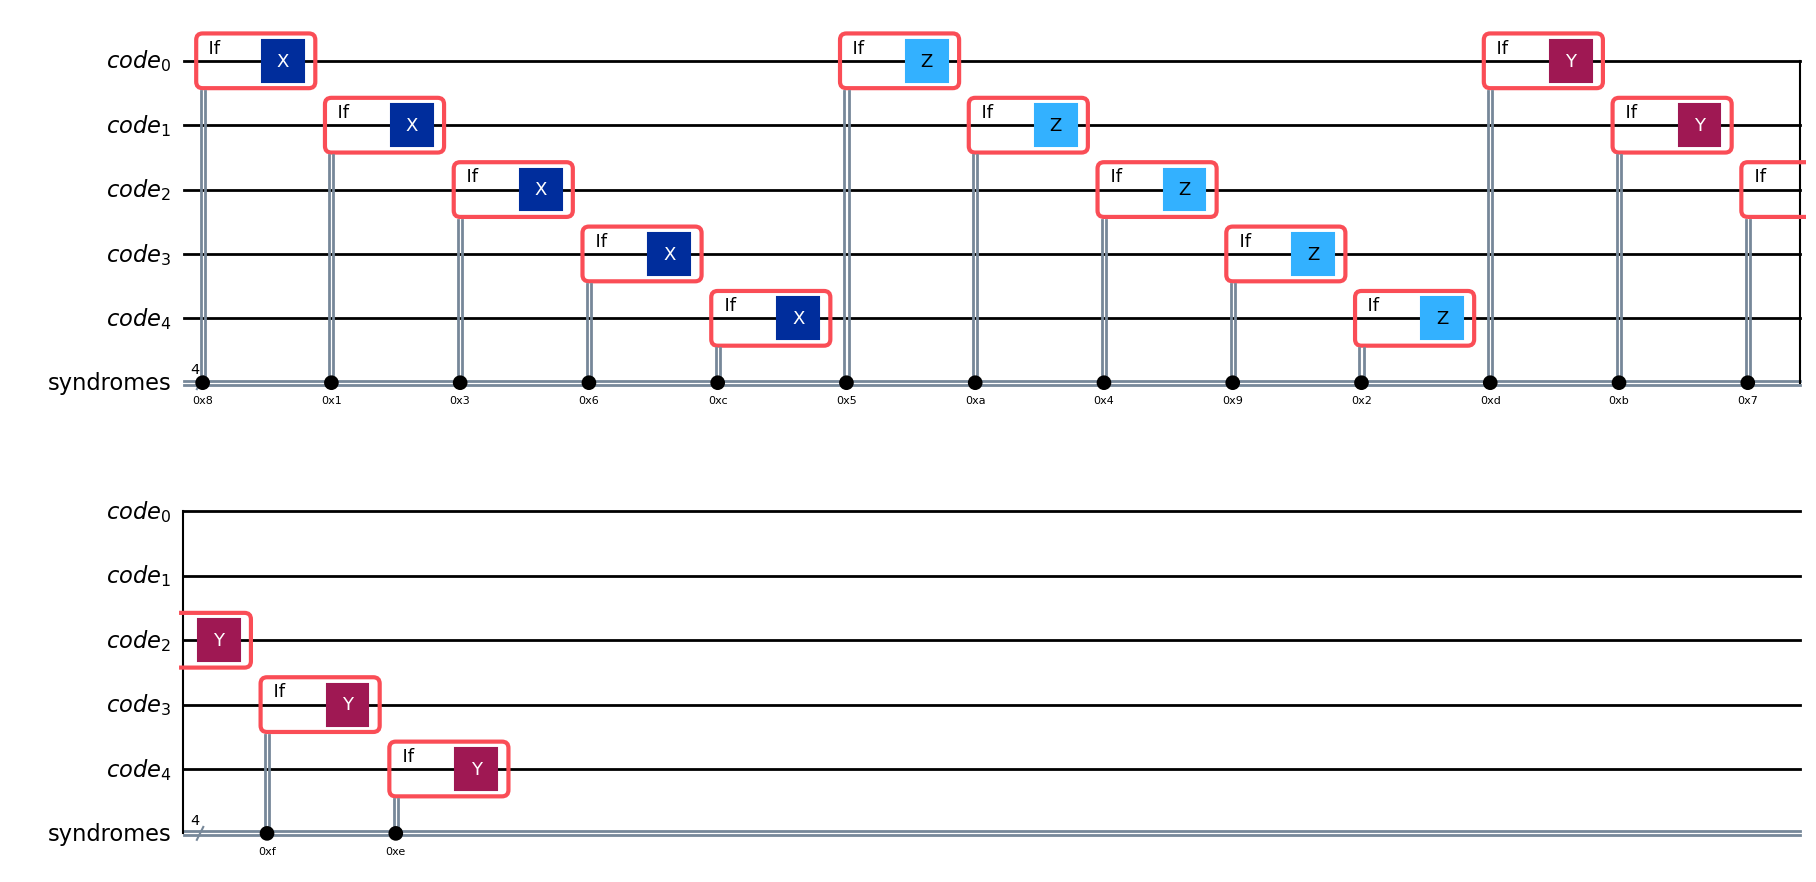

In [10]:
qc.draw(output='mpl')

## b) The Experiment
### b.i) Full Circuit and the Five Qubit QECC Class

All of the above circuit components (for encoding and measuring and correcting error) are implemented in a class, `Five_Qubit_QECC`, available in resources/five_qubit_QECC. As an example, the full circuit for a logical state of $\left|1_L\right>$ can be generated as follows. Note:
- The class we implement provides a method `get_logical_X()` that returns the logical $X$ gate, here $X$ gates on all the code qubits. We use apply this gate after the 'Logical 0 Preparation' gate to achieve $\left|1_L\right>$.
- We add identity gates on the code qubits after state preparation. These are where errors will be applied, later on.
- We include a final measurement of the code qubits after error correction.

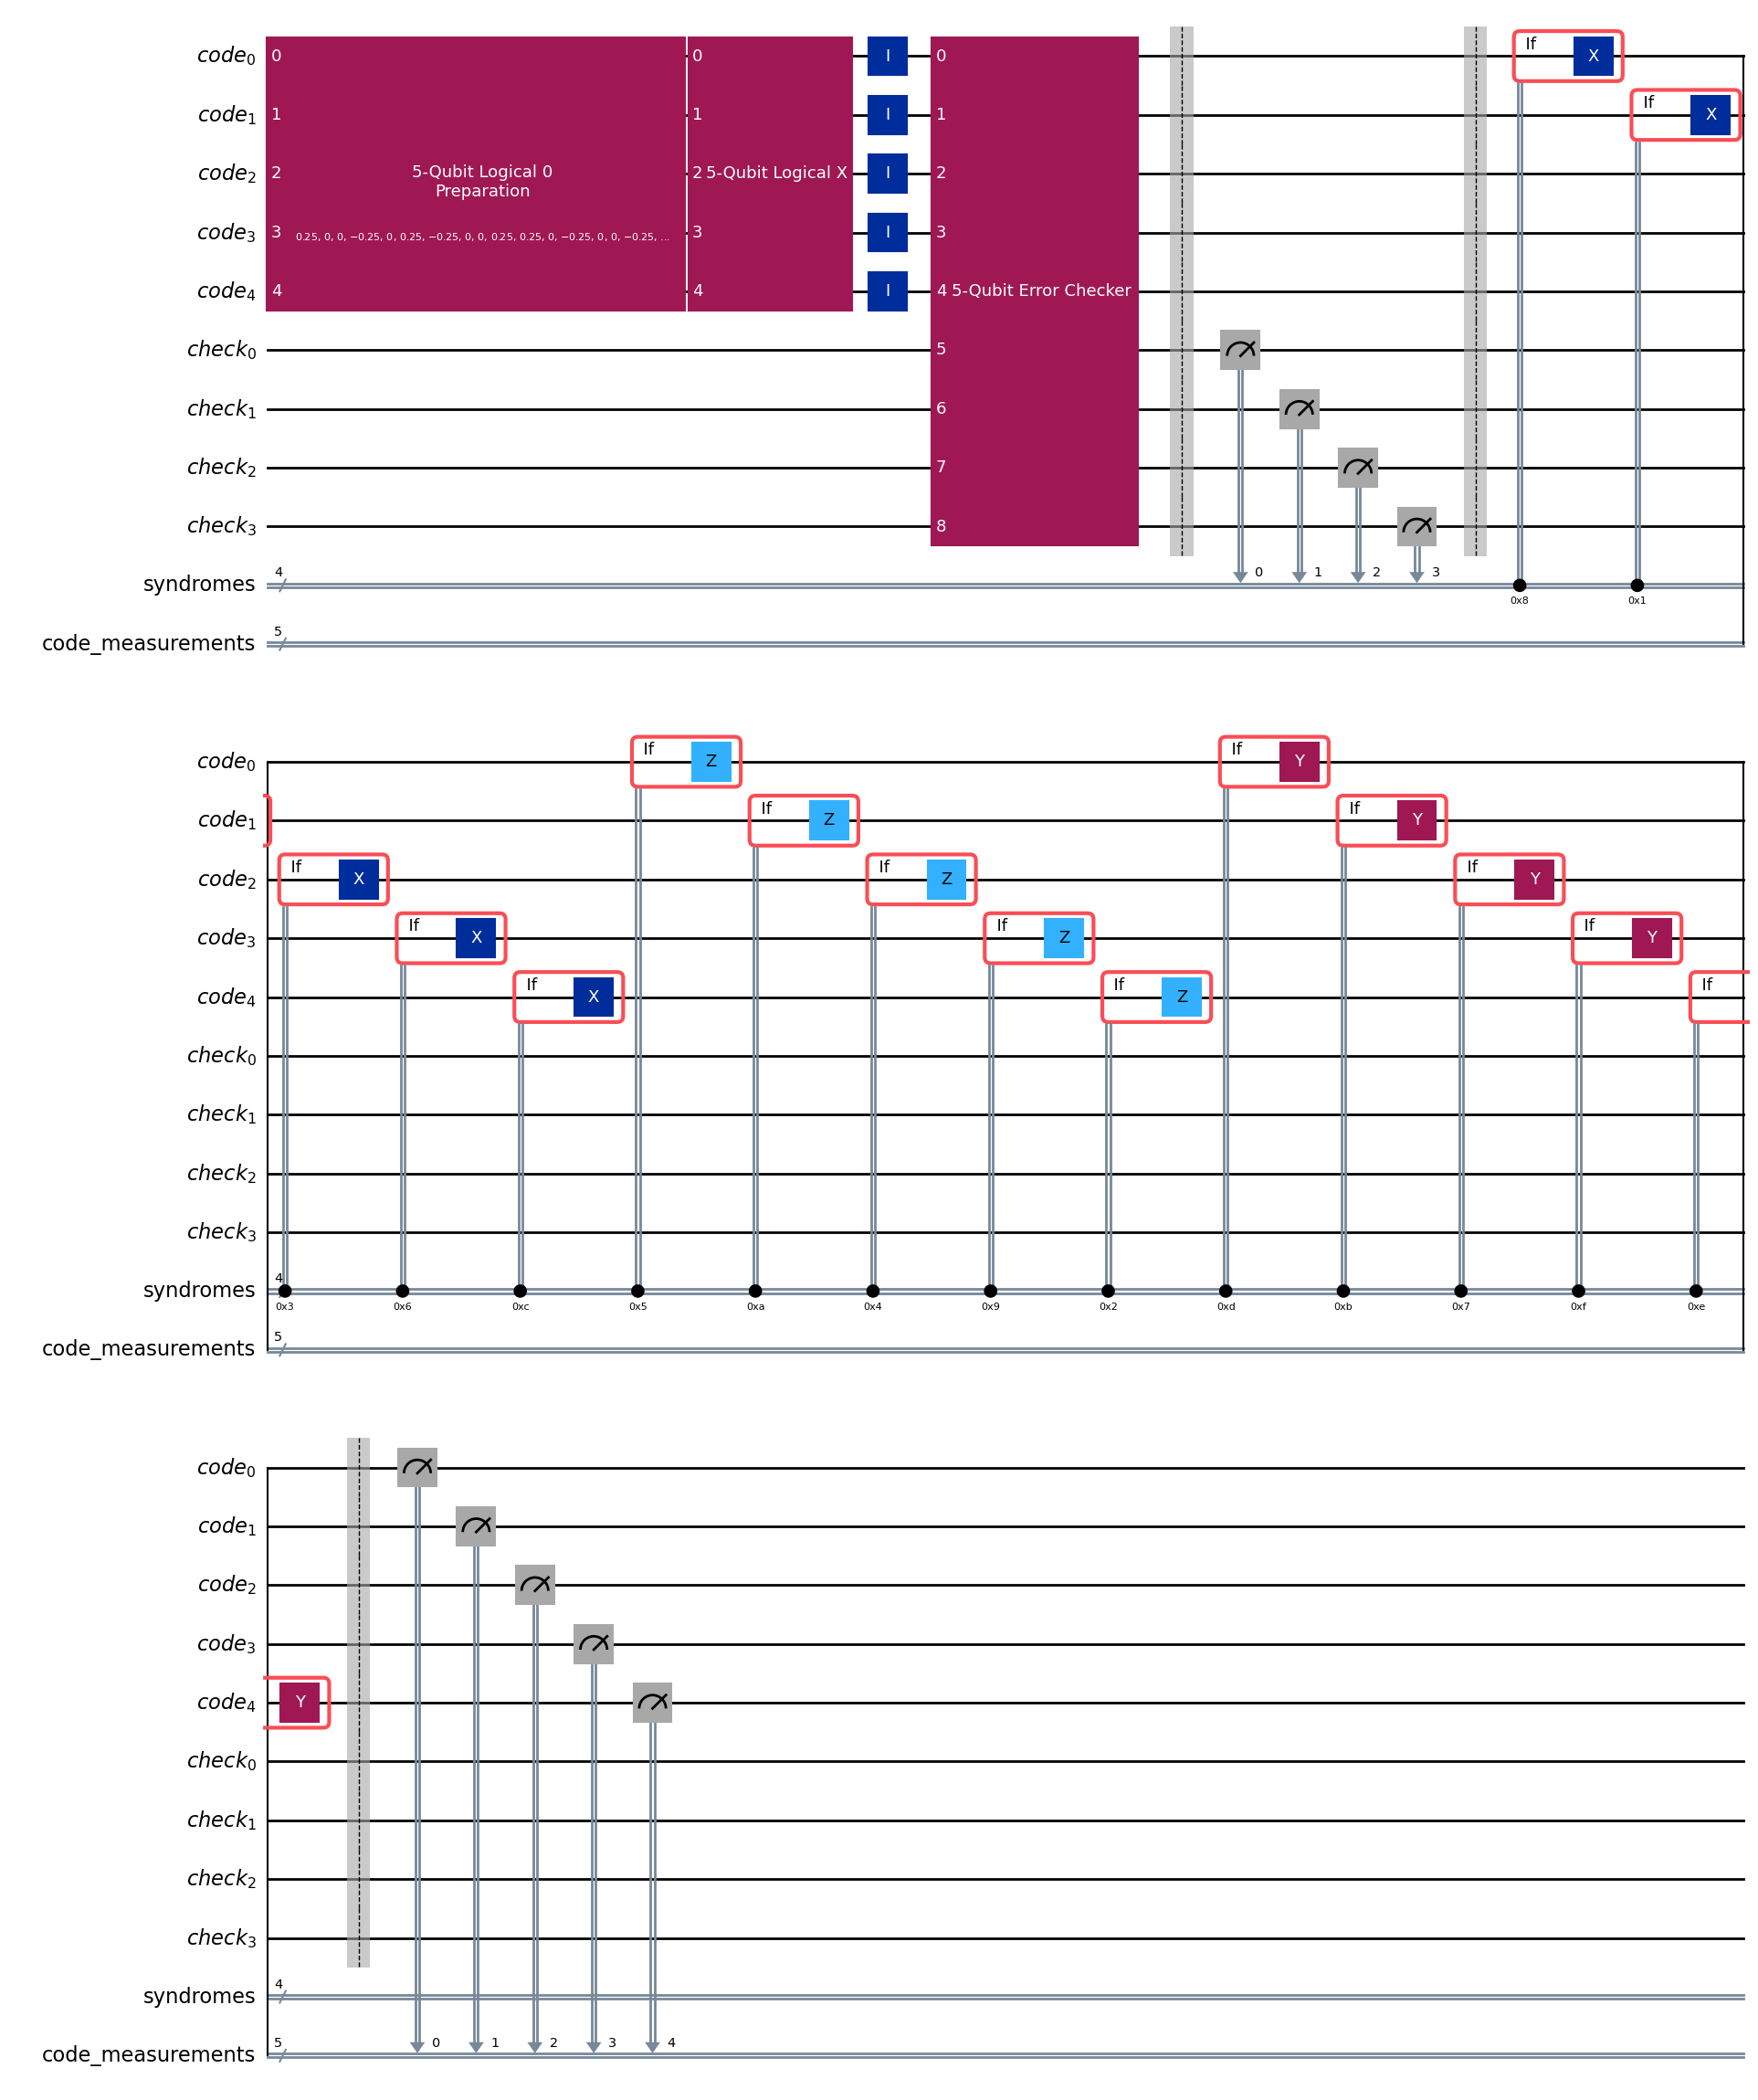

In [11]:
ecc = Five_Qubit_QECC()

five_qubit_qc = QuantumCircuit(qubits_code, qubits_checks, syndromes, clbits_code)
five_qubit_qc.compose(ecc.get_logical_0_preparer(), inplace=True)

# flip to logical 1 state
five_qubit_qc.compose(ecc.get_logical_X(), inplace=True)

# introduce errors
five_qubit_qc.id(qubits_code[:])

# add error corrector
five_qubit_qc.compose(ecc.get_error_corrector(), inplace=True)

# add measurement of code qubits
five_qubit_qc.barrier()
five_qubit_qc.measure(qubits_code, clbits_code)

five_qubit_qc.draw(output='mpl')


### b.ii) Simulation of the Circuit with Noise

We add noise by randomly adding a Pauli error to the identity gates in the Aer simulator. Then we run the circuit a number of times and record the fraction of successful measurements.

Note: in the class for the 5 Qubit Code, we also implement the `get_logical_0_components()` method that returns the list of bit string corresponding to the components of (i.e. the computation basis elements in) $\left|0_L\right>$. For the 5 Qubit Code, $\left|1_L\right>$ has the complementary set of components.

In [12]:
p = .1

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    pauli_error([('X',p), ('Y',p), ('Z',p), ('I', 1 - 3*p)])
    , ['id']
)
simulator = AerSimulator(noise_model=noise_model)

trials = 10000

# compile, run circuit, and get measurement counts
# note: optimization_level=0 is required so that identity gates are not eliminated
compiled_circuit = transpile(five_qubit_qc, simulator, optimization_level=0)
job = simulator.run(compiled_circuit, shots=trials)
counts = job.result().get_counts()

# count the number of successful measurement
count_correct = 0
for state in counts:
    if state[:5] not in ecc.get_logical_0_components(): # determine if the state is not a component of 0_L, then it will be a component of 1_L
        count_correct += counts[state]
count_correct/trials # success rate

0.7189

## c) The `test_QECC_random_Pauli_errors` Function
We implemented a function, defined in resources/test_QECC.py, that encapsulates the above circuit construction and simulation. Here is a basic usage example that repeats the same experiment as above:

In [13]:
from resources.test_QECC import test_QECC_random_Pauli_errors

probability = .1
test_QECC_random_Pauli_errors(probability, logical_state=1, trials=10000)

0.7094

We also implemented several additional features and options in this function.
## d) Additional Functionality and More Analysis of the 5-Qubit Code
### d.i) Sweeping Across $p$ Values

`test_QECC_random_Pauli_errors` allows for the input $p$ to be a list of probabilities, and, in that case, it outputs a corresponding list of success rates. This makes it easy to run a sweep across value of $p$ and visualize the performance of the 5 Qubit Code as a function of $p$:

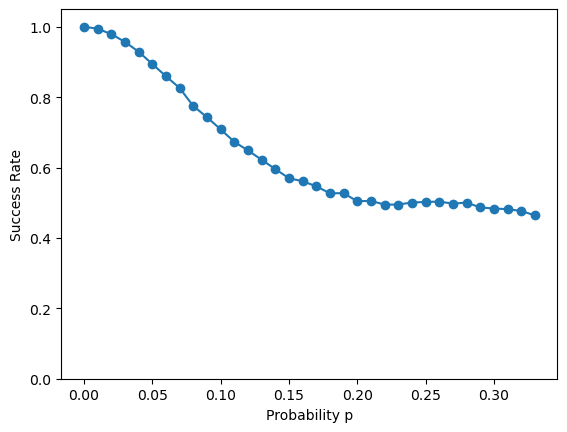

In [14]:
pList = list(np.arange(0,.34,.01))
frac_succesful = test_QECC_random_Pauli_errors(pList, trials=10000)
plt.plot(pList, frac_succesful,'-o')
plt.xlabel('Probability p')
plt.ylabel('Success Rate')
plt.ylim((0,1.05))
plt.show()

### d.ii) Selecting the Qubits Subject to Pauli Errors
`test_QECC_random_Pauli_errors` allows one to select a subset of code qubit subject to the Pauli errors using the `error_locations` option. This allows, for example, for the following sanity check. The 5 Qubit Code should perfectly handle all instances of a single Pauli error. Setting `error_locations = [0]` will limit the errors to a single Pauli gate on the first qubit. And, indeed, the success rate is $1$ for all values of $p$:

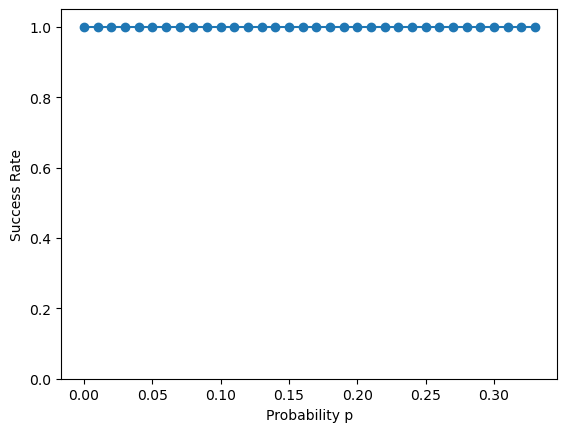

In [15]:
frac_succesful = test_QECC_random_Pauli_errors(pList, trials=10000, error_locations = [0])
plt.plot(pList, frac_succesful,'-o')
plt.xlabel('Probability p')
plt.ylabel('Success Rate')
plt.ylim((0,1.05))
plt.show()

Note: due to the cyclic symmetry in the code, the same will hold true for any choice of one qubit to (possibly) recieve an error. Similarly, if all but one qubit can recieve errors, the result of this experiment should be statistically equivalent no matter which qubit that is. Comparing the plots from two such choices serves as another sanity check:

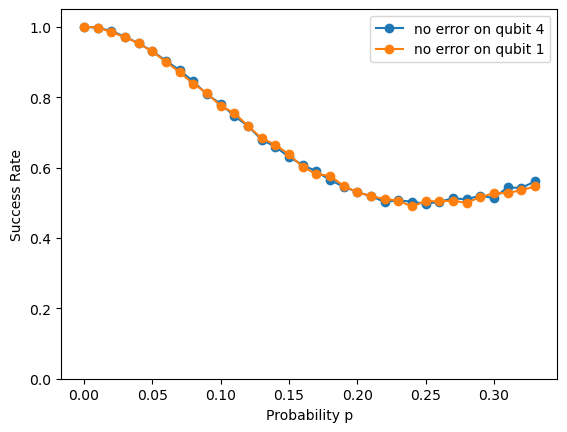

In [16]:
frac_succesful_no_4 = test_QECC_random_Pauli_errors(pList, trials=10000, error_locations = [0,1,2,3])
frac_succesful_no_1 = test_QECC_random_Pauli_errors(pList, trials=10000, error_locations = [0,2,3,4])
plt.plot(pList, frac_succesful_no_4,'-o')
plt.plot(pList, frac_succesful_no_1,'-o')
plt.xlabel('Probability p')
plt.ylabel('Success Rate')
plt.ylim((0,1.05))
plt.legend(['no error on qubit 4', 'no error on qubit 1'])
plt.show()

### d.iii) Another Metric / Experiment Type
Instead of immediately measuring the code qubits after error correction, `test_QECC_random_Pauli_errors` also allows for a experiment where the qubits are first decoded then measured. If the error correction was successful, the measurement should result in the all $0$s state.

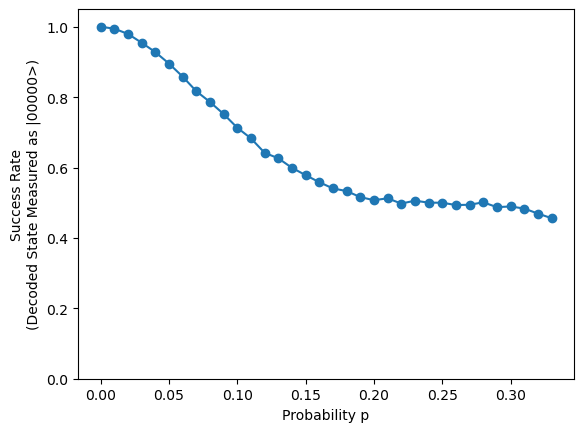

In [17]:
frac_succesful = test_QECC_random_Pauli_errors(pList, measurement_type='decoded', trials=10000)
plt.plot(pList, frac_succesful,'-o')
plt.xlabel('Probability p')
plt.ylabel('Success Rate\n(Decoded State Measured as |00000>)')
plt.ylim((0,1.05))
plt.show()

The above, alternative experiment type is useful for comparison with other error correcting codes, since $\left|0_L\right>$ and $\left|1_L\right>$ do not have disjoint sets of components in most codes.

### d.iv) Other Codes
`test_QECC_random_Pauli_errors` can also test other codes, provided a class object for that code via the optional argument `ecc`. We implemented a class `Shor_QECC` for Shor's code, in resources/Shor_QECC.py, allowing us to compare the performance of the 5-qubit code and Shor's code: 

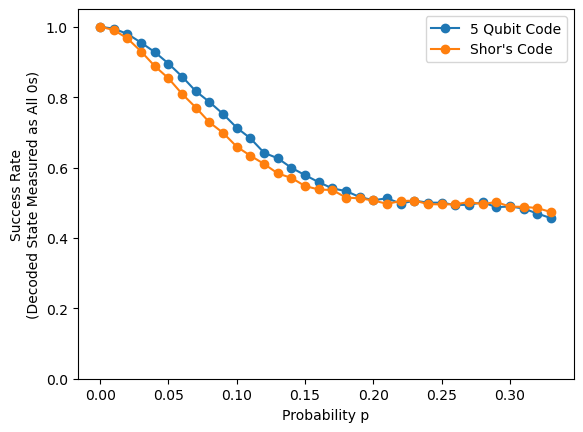

In [18]:
from resources.Shor_QECC import *
frac_succesful_shor = test_QECC_random_Pauli_errors(pList, measurement_type='decoded', ecc=Shor_QECC(), trials=10000)

plt.plot(pList, frac_succesful, '-o')
plt.plot(pList, frac_succesful_shor, '-o')
plt.xlabel('Probability p')
plt.ylabel('Success Rate\n(Decoded State Measured as All 0s)')
plt.ylim((0,1.05))
plt.legend(['5 Qubit Code', 'Shor\'s Code'])
plt.show()

It seems like, by this metric, the 5 Qubit Code has a very slight advantage over Shor's code for moderate values of $p$. The closeness of their performance might reflect a trade-off. While both codes have distance $3$, Shor's code can perfectly correct for some multiple-qubit errors, while the 5 Qubit Code can not correct any. That should give the advantage to Shor's code. But, since Shor's code uses more physical qubits, there is greater opportunity for errors to occur in each logical qubit, at least under this model of noise.